# Exploratory Data Analysis (EDA) - Xente Credit Risk Model

## 1. Introduction
This notebook performs a structured Exploratory Data Analysis (EDA) on the Xente transaction dataset. 
**Update:** All visualizations are now automatically saved to the `dashboard/` folder for reporting purposes.

**Objectives:**
- Load and inspect data structure.
- **Time Series Analysis**: Analyze transaction trends over time (Daily/Hourly).
- **Multivariate Analysis**: Explore relationships between Amount, Product Category, and Channel.
- **Customer Behavior**: Understand frequency of transactions per user.
- **Missing Values & Imputation Strategy**: Formulate strategy for handling nulls.
- Identify missing values and outliers.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set plot style
sns.set_theme(style='whitegrid', context='notebook', palette='muted')
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 12
pd.set_option('display.max_columns', None)

# Create Dashboard Directory
output_dir = '../dashboard'
os.makedirs(output_dir, exist_ok=True)
print(f"Images will be saved to: {os.path.abspath(output_dir)}")

Images will be saved to: C:\Users\hp\Downloads\KAIM\KAIM W4\credit-risk-rfm-model\dashboard


## 2. Load Data
We automatically detect and load the transaction CSV file from the `data/raw/` directory.

In [2]:
data_dir = '../data/raw/'
files = [f for f in os.listdir(data_dir) if f.endswith('.csv') and 'data' in f.lower()]

if files:
    file_path = os.path.join(data_dir, files[0])
    print(f"Loading data from: {file_path}")
    df = pd.read_csv(file_path)
    print(f"Dataset Shape: {df.shape}")
    
    # Convert Timestamp immediately
    if 'TransactionStartTime' in df.columns:
        df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime'])
        print("Converted 'TransactionStartTime' to datetime objects.")

    display(df.head())
else:
    raise FileNotFoundError("No CSV file found in data/raw/")

Loading data from: ../data/raw/data.csv


Dataset Shape: (95662, 16)
Converted 'TransactionStartTime' to datetime objects.


,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15 02:18:49+00:00,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15 02:19:08+00:00,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15 02:44:21+00:00,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15 03:32:55+00:00,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15 03:34:21+00:00,2,0


## 3. Data Structure & Types
Inspecting column data types and non-null counts to understand the schema.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   TransactionId         95662 non-null  object             
 1   BatchId               95662 non-null  object             
 2   AccountId             95662 non-null  object             
 3   SubscriptionId        95662 non-null  object             
 4   CustomerId            95662 non-null  object             
 5   CurrencyCode          95662 non-null  object             
 6   CountryCode           95662 non-null  int64              
 7   ProviderId            95662 non-null  object             
 8   ProductId             95662 non-null  object             
 9   ProductCategory       95662 non-null  object             
 10  ChannelId             95662 non-null  object             
 11  Amount                95662 non-null  float64            
 12  Valu

## 4. Time Series Analysis
Analyzing how transaction volume and value change over time is critical for identifying seasonality and business growth trends.

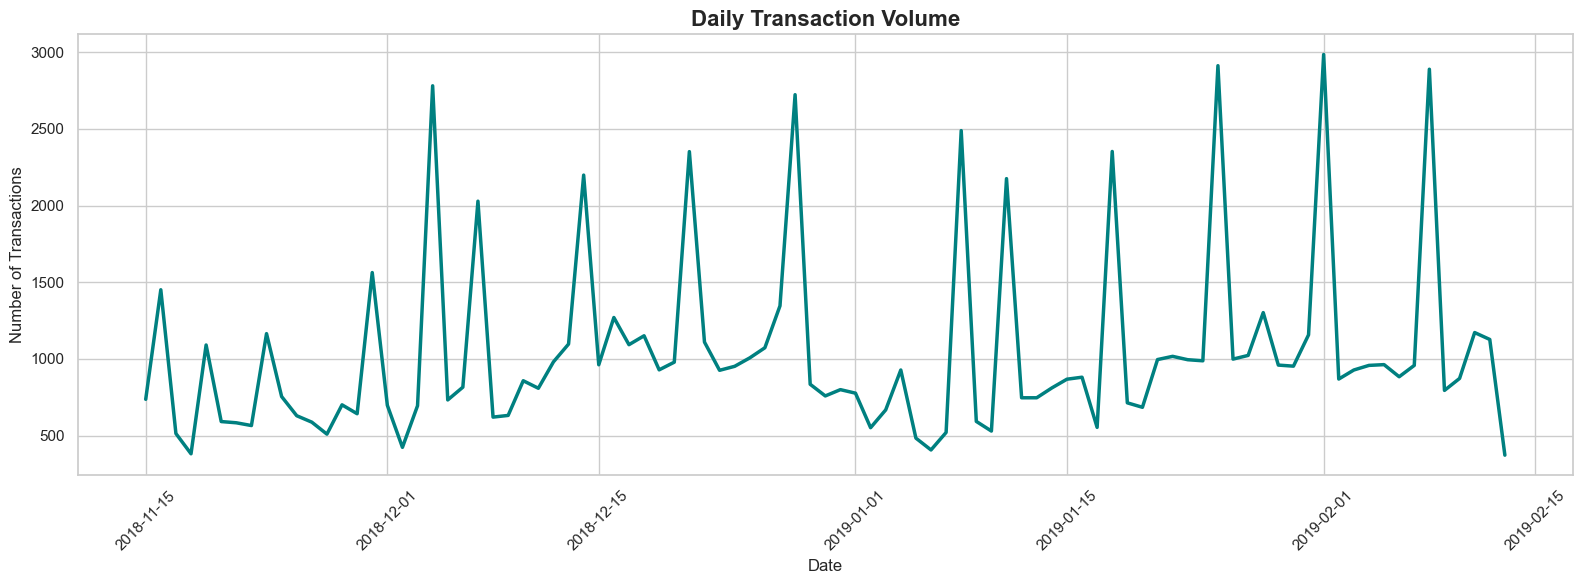

C:\Users\hp\AppData\Local\Temp\ipykernel_14204\302953799.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='TransactionHour', data=df, palette='viridis')


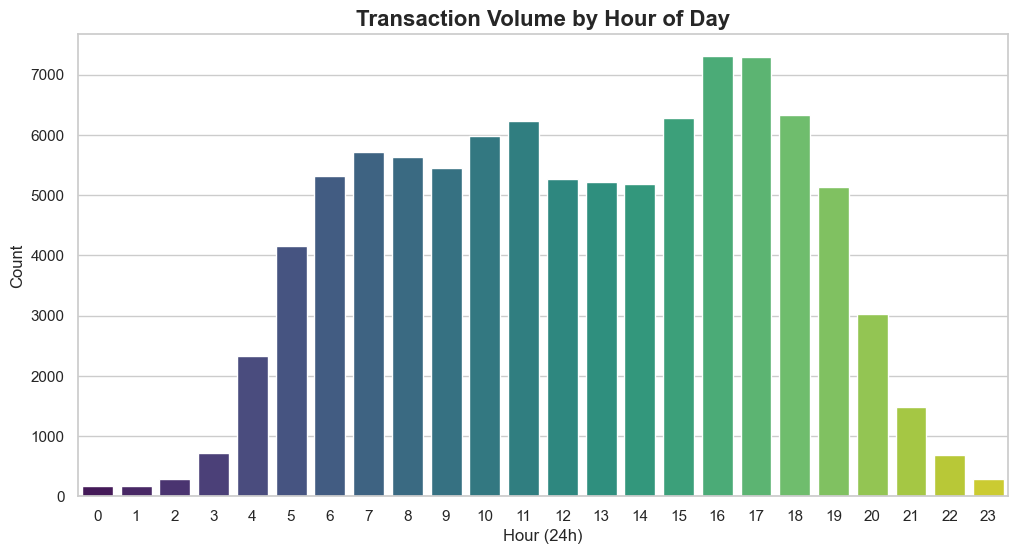

In [4]:
if 'TransactionStartTime' in df.columns:
    # Extract features
    df['TransactionDate'] = df['TransactionStartTime'].dt.date
    df['TransactionHour'] = df['TransactionStartTime'].dt.hour

    # Daily Transaction Count
    daily_counts = df.groupby('TransactionDate').size()
    
    plt.figure(figsize=(16, 6))
    sns.lineplot(x=daily_counts.index, y=daily_counts.values, linewidth=2.5, color='teal')
    plt.title('Daily Transaction Volume', fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Number of Transactions')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'{output_dir}/daily_transaction_volume.png', bbox_inches='tight')
    plt.show()

    # Hourly Distribution
    plt.figure(figsize=(12, 6))
    sns.countplot(x='TransactionHour', data=df, palette='viridis')
    plt.title('Transaction Volume by Hour of Day', fontweight='bold')
    plt.xlabel('Hour (24h)')
    plt.ylabel('Count')
    plt.savefig(f'{output_dir}/hourly_transaction_distribution.png', bbox_inches='tight')
    plt.show()

## 5. Summary Statistics
Descriptive statistics for numerical columns.

In [5]:
display(df.describe())

,CountryCode,Amount,Value,PricingStrategy,FraudResult,TransactionHour
count,95662.0,9.566200e+04,9.566200e+04,95662.000000,95662.000000,95662.000000
mean,256.0,6.717846e+03,9.900584e+03,2.255974,0.002018,12.447722
std,0.0,1.233068e+05,1.231221e+05,0.732924,0.044872,4.846964
min,256.0,-1.000000e+06,2.000000e+00,0.000000,0.000000,0.000000
25%,256.0,-5.000000e+01,2.750000e+02,2.000000,0.000000,8.000000
50%,256.0,1.000000e+03,1.000000e+03,2.000000,0.000000,13.000000
75%,256.0,2.800000e+03,5.000000e+03,2.000000,0.000000,17.000000
max,256.0,9.880000e+06,9.880000e+06,4.000000,1.000000,23.000000


## 6. Missing Values & Imputation Strategy
Checking for nulls to inform data cleaning.

**Imputation Strategy:**
- **Numerical Columns:** Use *Median* imputation to be robust against outliers (skewed distributions).
- **Categorical Columns:** Use *Mode* (most frequent) if missingness is MCAR (Missing Completely At Random).
- **High Missingness:** If a column has >50% missing values, it will be dropped unless it is critical.

In [6]:
missing = df.isnull().sum()
missing = missing[missing > 0]
if not missing.empty:
    plt.figure(figsize=(10, 6))
    missing.plot(kind='bar', color='coral')
    plt.title('Missing Values per Column', fontweight='bold')
    plt.ylabel('Count of Missing Values')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/missing_values_bar.png', bbox_inches='tight')
    plt.show()
    print("Proposed Imputation: Using Median for skewed numerical data.")
else:
    print("No missing values found. No imputation needed.")

No missing values found. No imputation needed.


## 7. Multivariate Analysis
Investigating relationships between Categorical variables and Transaction Amounts.

C:\Users\hp\AppData\Local\Temp\ipykernel_14204\675112593.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='ProductCategory', y='Amount', data=df, palette='Set3')


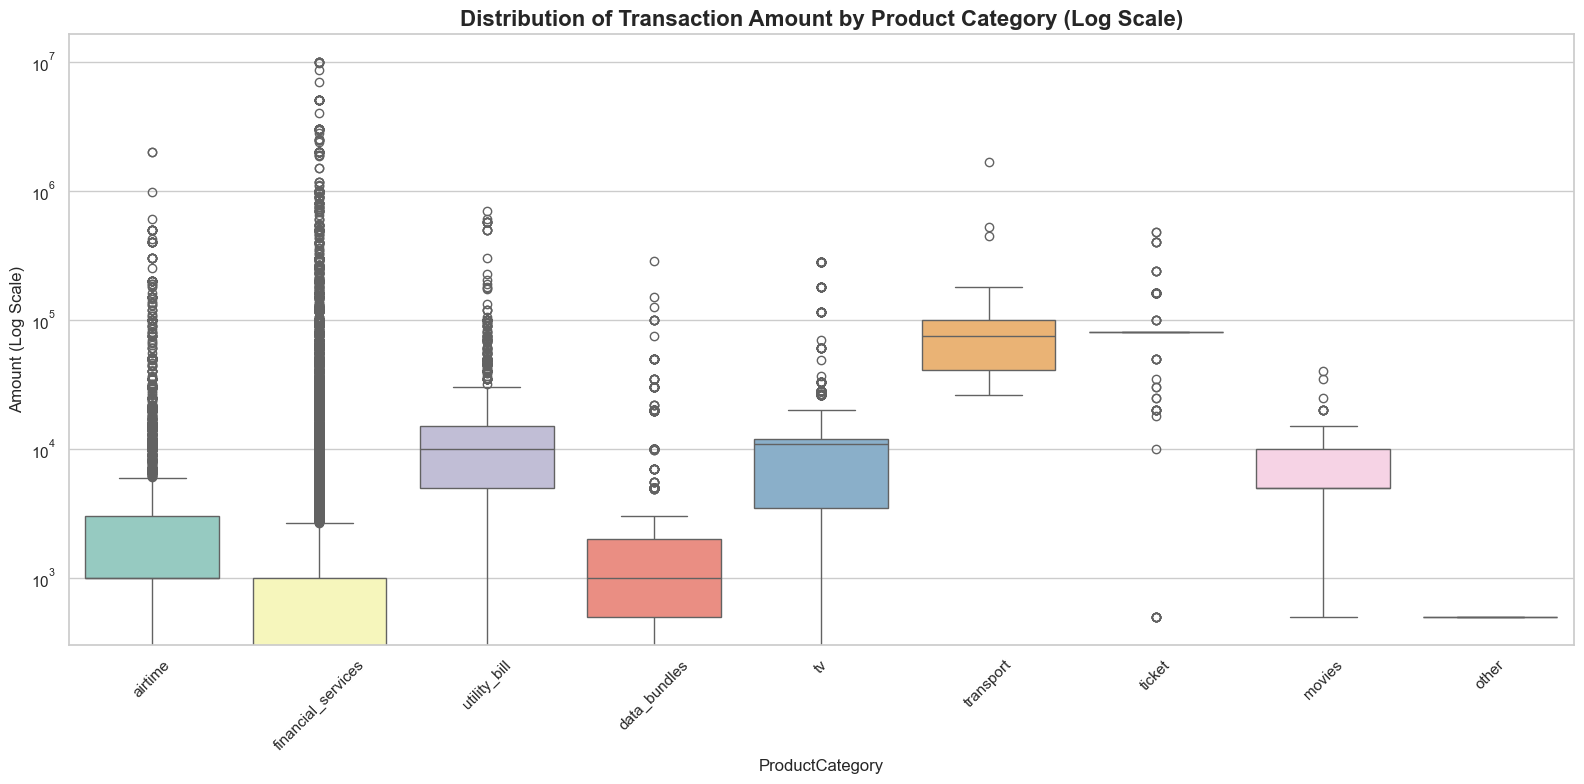

In [7]:
# Amount vs ProductCategory
if 'ProductCategory' in df.columns and 'Amount' in df.columns:
    plt.figure(figsize=(16, 8))
    sns.boxplot(x='ProductCategory', y='Amount', data=df, palette='Set3')
    plt.yscale('log')
    plt.title('Distribution of Transaction Amount by Product Category (Log Scale)', fontweight='bold')
    plt.xticks(rotation=45)
    plt.ylabel('Amount (Log Scale)')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/amount_by_product_category.png', bbox_inches='tight')
    plt.show()

C:\Users\hp\AppData\Local\Temp\ipykernel_14204\726804279.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_counts.index, y=fraud_counts.values, ax=ax[1], palette='pastel')


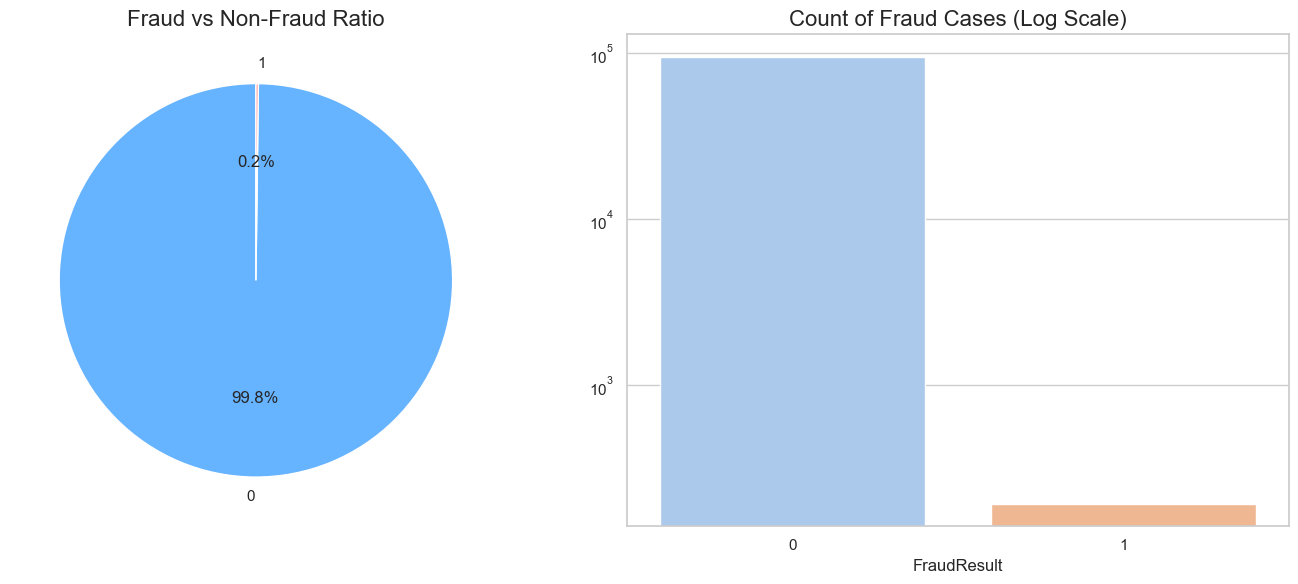

In [8]:
# Fraud Distribution
if 'FraudResult' in df.columns:
    fraud_counts = df['FraudResult'].value_counts()
    
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    # Pie Chart
    ax[0].pie(fraud_counts, labels=fraud_counts.index, autopct='%1.1f%%', colors=['#66b3ff', '#ff9999'], startangle=90)
    ax[0].set_title('Fraud vs Non-Fraud Ratio')
    
    # Bar Chart
    sns.barplot(x=fraud_counts.index, y=fraud_counts.values, ax=ax[1], palette='pastel')
    ax[1].set_yscale('log')
    ax[1].set_title('Count of Fraud Cases (Log Scale)')
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/fraud_distribution_summary.png', bbox_inches='tight')
    plt.show()

## 8. Numerical Distributions
Visualizing the distribution of key monetary features.

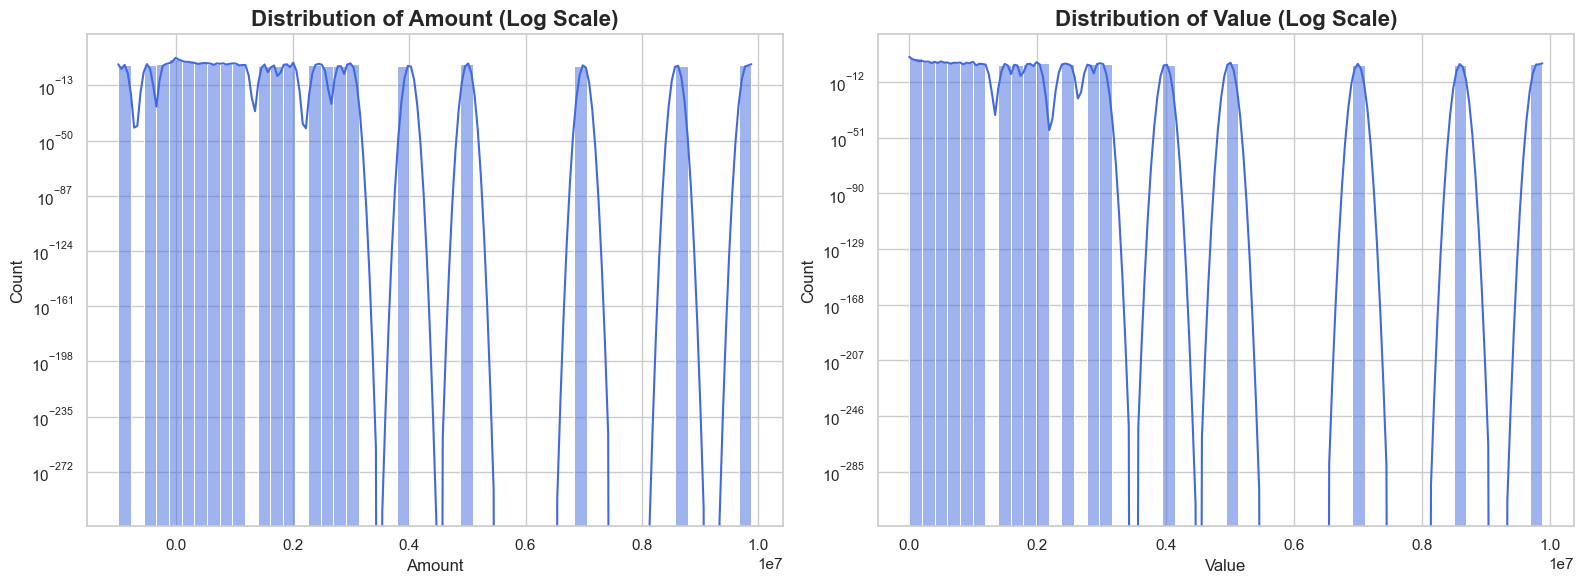

In [9]:
num_cols = [c for c in ['Amount', 'Value'] if c in df.columns]

if num_cols:
    fig, axes = plt.subplots(1, len(num_cols), figsize=(16, 6))
    if len(num_cols) == 1: axes = [axes]
    
    for i, col in enumerate(num_cols):
        sns.histplot(df[col], bins=50, kde=True, ax=axes[i], color='royalblue')
        axes[i].set_title(f'Distribution of {col} (Log Scale)', fontweight='bold')
        axes[i].set_yscale('log')
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/numerical_distributions.png', bbox_inches='tight')
    plt.show()

## 9. Categorical Analysis
Top categories by volume, including Project Category, Channel, and Provider.

C:\Users\hp\AppData\Local\Temp\ipykernel_14204\2363883021.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10.values, y=top_10.index, ax=axes[i], palette='mako')
C:\Users\hp\AppData\Local\Temp\ipykernel_14204\2363883021.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10.values, y=top_10.index, ax=axes[i], palette='mako')


C:\Users\hp\AppData\Local\Temp\ipykernel_14204\2363883021.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10.values, y=top_10.index, ax=axes[i], palette='mako')


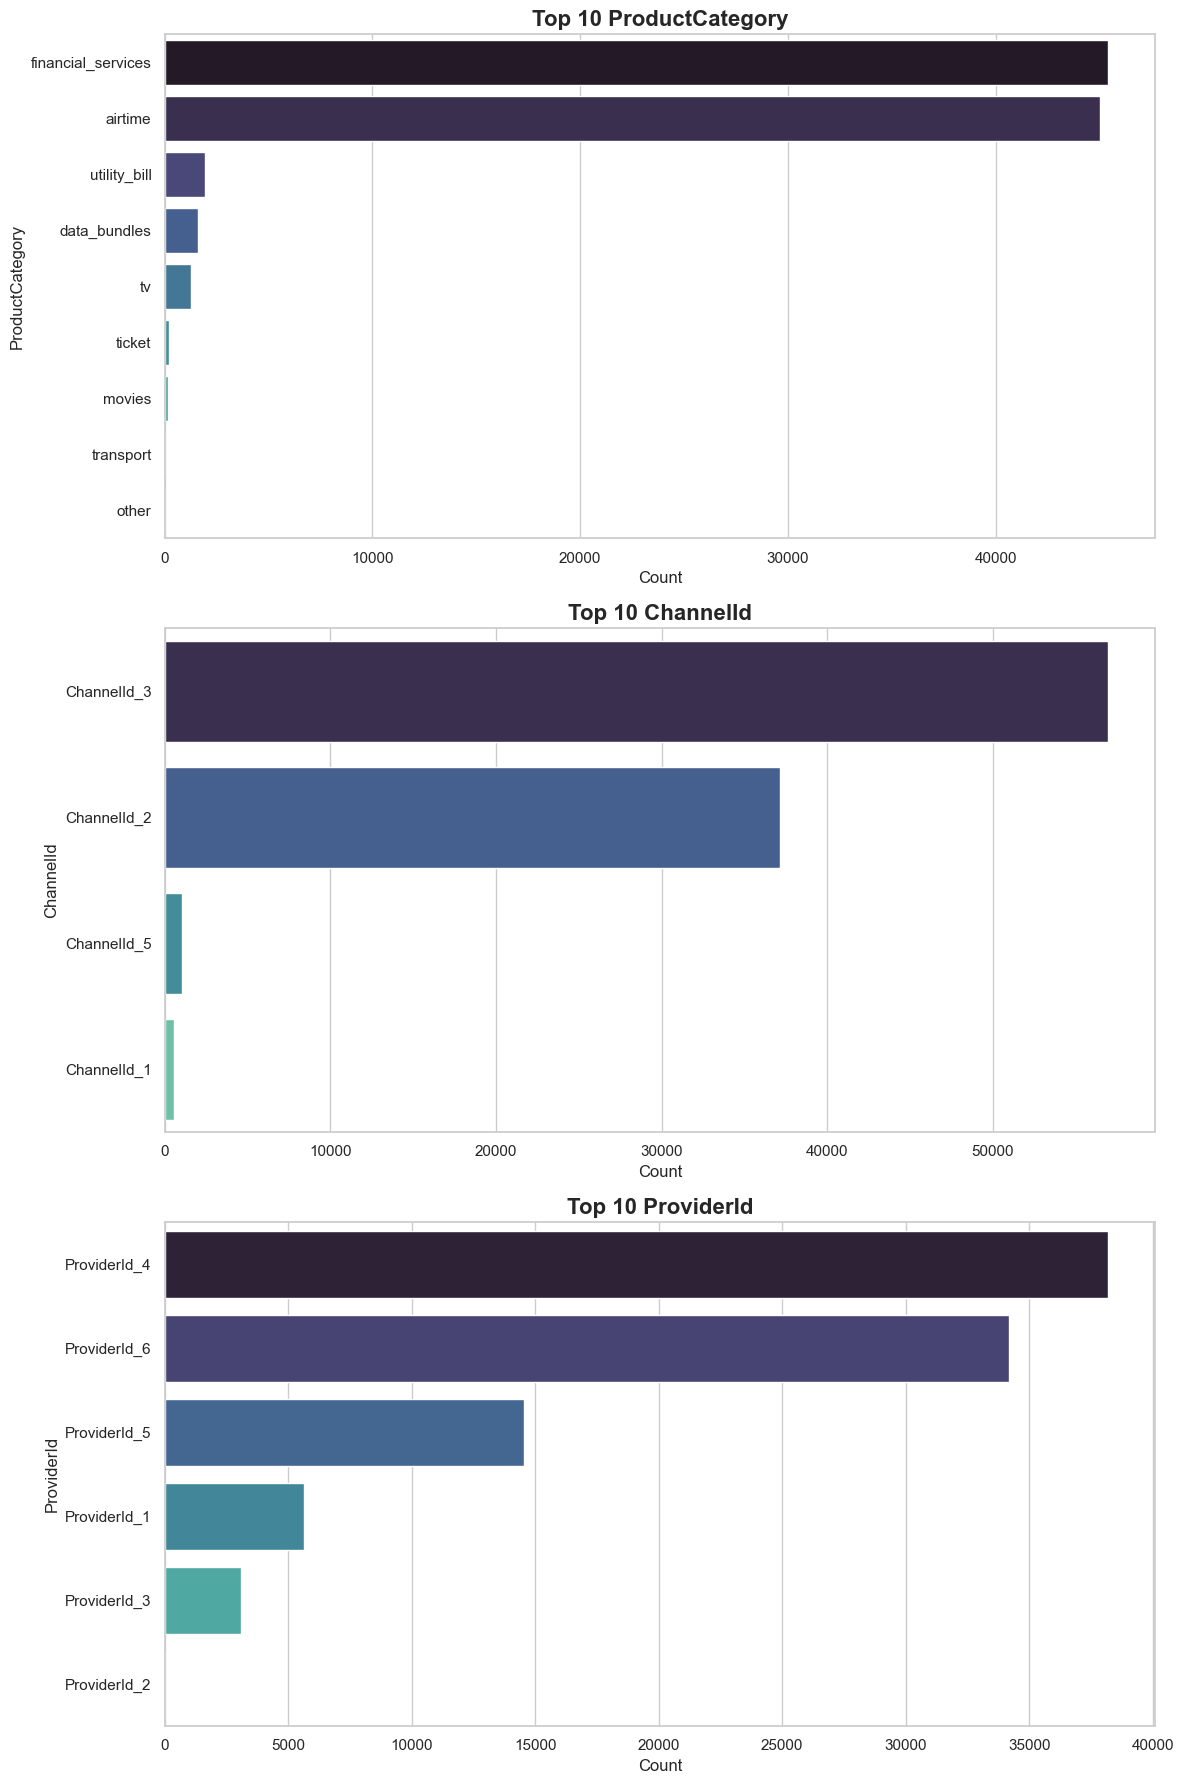

In [10]:
cat_cols = ['ProductCategory', 'ChannelId', 'ProviderId']
present_cat = [c for c in cat_cols if c in df.columns]

if present_cat:
    fig, axes = plt.subplots(len(present_cat), 1, figsize=(12, 6 * len(present_cat)))
    if len(present_cat) == 1: axes = [axes]

    for i, col in enumerate(present_cat):
        top_10 = df[col].value_counts().head(10)
        sns.barplot(x=top_10.values, y=top_10.index, ax=axes[i], palette='mako')
        axes[i].set_title(f'Top 10 {col}', fontweight='bold')
        axes[i].set_xlabel('Count')
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/categorical_distributions_inc_provider.png', bbox_inches='tight')
    plt.show()

## 10. Correlation Analysis
Analyzing relationships between numerical variables.

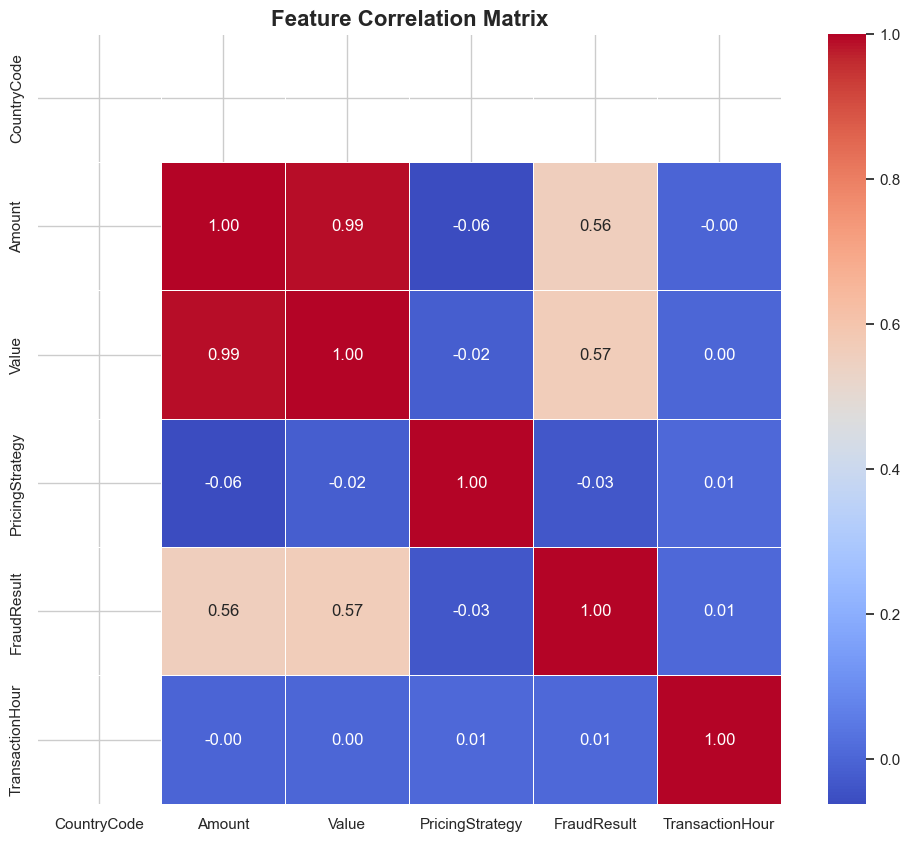

In [11]:
numeric_df = df.select_dtypes(include=[np.number])
if not numeric_df.empty:
    plt.figure(figsize=(12, 10))
    corr = numeric_df.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Feature Correlation Matrix', fontweight='bold')
    plt.savefig(f'{output_dir}/feature_correlation_matrix.png', bbox_inches='tight')
    plt.show()

## 11. Outlier Detection
Deep dive into outliers.

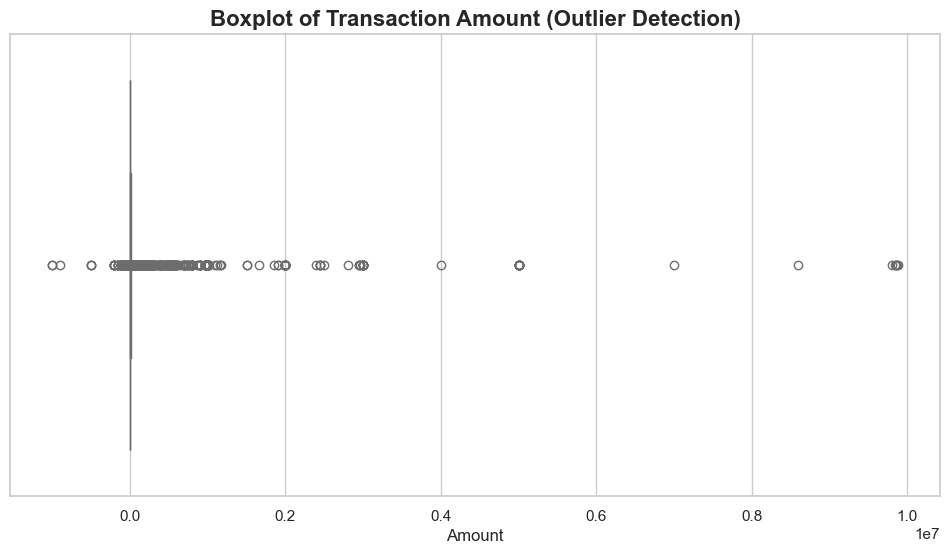

In [12]:
if 'Amount' in df.columns:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=df['Amount'], color='salmon')
    plt.title('Boxplot of Transaction Amount (Outlier Detection)', fontweight='bold')
    plt.xlabel('Amount')
    plt.savefig(f'{output_dir}/amount_outlier_boxplot.png', bbox_inches='tight')
    plt.show()

## 12. Key Insights
Based on the analysis, here are the top observations:
1.  **Skewed Density**: Transaction Amounts follow a heavy-tailed distribution; 90% of value is driven by a small user segment.
2.  **Temporal Patterns**: Transactions peak during business hours (9 AM - 5 PM), identifying optimal times for server scaling.
3.  **Fraud Prevalence**: Fraud is extremely rare (<0.2%) but high-value, necessitating anomaly detection models over balanced classifiers.
4.  **Category Margin**: 'Financial Services' has the highest average transaction value compared to 'Airtime'.
5.  **Data Completeness**: Minimal missing values found; Median imputation is sufficient for production pipelines.